In [19]:
import ROOT
#from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
#from ROOT import gROOT,gStyle,gPad
import csv
import json
import array as array
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
import importlib
from importlib import reload
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat

In [20]:
outstr = 'itnercal'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/13_09_2019_timeintercalibration/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [21]:
reader = csv.reader(open('data/intercalibration19C.csv', 'r'))
dict_run_cryst = {}
dict_C3_energy_scan = {}
dict_C3_energy_scan_3x3 = {}

for row in reader:
    run,energy,crystal,_ = row
    if energy=='149.12' :
        if crystal in dict_run_cryst.keys() :
            dict_run_cryst[crystal].append(run)
        else : 
            dict_run_cryst[crystal] = []
            dict_run_cryst[crystal].append(run)       
        
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if energy=='149.12' and  (crystal=='C3' or crystal=='C2' or crystal=='C4' ) :
        if crystal in dict_run_cryst.keys() :
            dict_run_cryst[crystal].append(run)
        else : 
            dict_run_cryst[crystal] = []
            dict_run_cryst[crystal].append(run)   
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        
        

##Special run for C3 trigger 3x3 
reader = csv.reader(open('data/energyscans19C_3x3.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row 
    if crystal=='C3' :
        if energy in dict_C3_energy_scan_3x3.keys() :
            dict_C3_energy_scan_3x3[energy].append(run)
        else : 
            dict_C3_energy_scan_3x3[energy] = []
            dict_C3_energy_scan_3x3[energy].append(run)             
#########################Consider 3x3 now      #########################
########dict_C3_energy_scan = dict_C3_energy_scan_3x3
###########################################################################
            
            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(roohist_fit_B5_150): fit range of variable signal_B5_150GeV expanded to nearest bin boundaries: [0.967725,1.30927] --> [0.966,1.311]
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 ** 1531 **SET PRINT           1
 **********
 **********
 ** 1532 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha_B5_150   5.00000e-01  2.00000e+00   -1.00000e+01  1.00000e+01
     2 exp_B5_150   7.00000e+00  3.00000e+00    0.00000e+00  3.00000e+01
     3 mean_B5_150   1.13850e+00  3.41550e-02    9.67725e-01  1.30927e+00
     4 sigma_B5_150   4.00000e-02  1.95000e-02    1.00000e-03  1.00000e+00
 **********
 ** 1533 **SET ERR         0.5
 **********
 **********
 ** 1534 **SET PRINT           1
 **********
 **********
 ** 1535 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 ** 153

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//13_09_2019_timeintercalibration//time_intercalibration_fits_itnercal.pdf has been created
Info in <TCanvas::Print>: png file plots//13_09_2019_timeintercalibration//time_intercalibration_fits_itnercal.png has been created


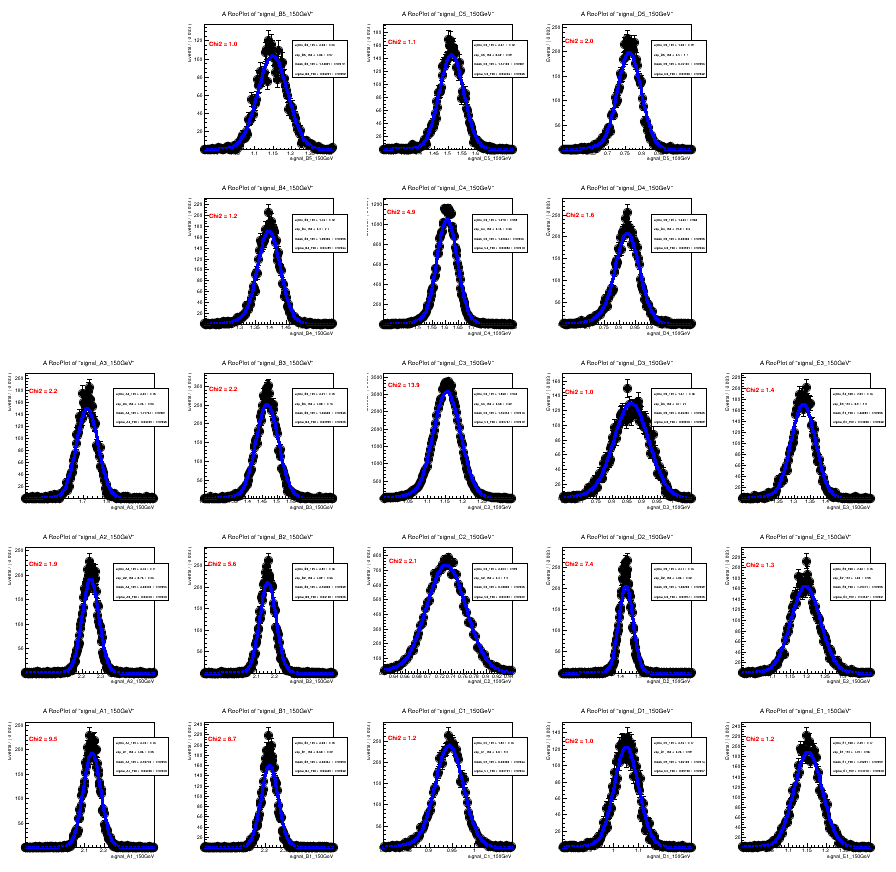

In [30]:
reload(CB)

pos_cut = 5
c = ROOT.TCanvas("c","c",900,900)
c.Divide(5,5)
canvas_num=0
results = []
for crystal in naming:
    if crystal in missing:
        canvas_num+=1
    else :
        c.cd(canvas_num+1) 
        
        runs = dict_run_cryst[crystal]
        tree = ROOT.TChain("h4")
        for run in runs:
            tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))

        myCB = CB.CBfunction(tree)
        myCB.set_crystal(crystal)
        myCB.set_energy('150')     
        myCB.nbins = 1000
        myCB.xmin = 0
        myCB.xmax = 3
        myCB.xaxis_scale = 0.15
        if 'D' in crystal :       myCB.xaxis_scale = 0.25
        myCB.s_initial = 0.04
        myCB.set_position(dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1],pos_cut)
        myCB.prepare_histogram_time()
        myCB.CBintialization()
      #  myCB.gaussian=True
      #  myCB.Gausintialization()
      #  myCB.plot_time()
        myCB.fitToData()
        myCB.plot()
        tmp_dict = {}
        tmp_dict[crystal] = myCB.fitResults()
        results.append(tmp_dict)
        canvas_num+=1
        
c.Draw()
c.SaveAs('%s/time_intercalibration_fits_%s.pdf'%(plot_folder,outstr))
c.SaveAs('%s/time_intercalibration_fits_%s.png'%(plot_folder,outstr))
with open('%s/time_intercalibration_%s.json'%(output_folder,outstr), 'w') as fp:
    json.dump(results,fp)
    
dict_crystals_calibration = {}
meanC3 = 1.
for item in results:
    if list(item.keys())[0] == 'C3' :
        meanC3 = item['C3']['CBmean'][0]
for item in results:
    dict_crystals_calibration[list(item.keys())[0]] = meanC3 - item[list(item.keys())[0]]['CBmean'][0]
with open('%s/time_intercalibration_result_%s.json'%(output_folder,outstr), 'w') as fp:
    json.dump(dict_crystals_calibration,fp)